In [304]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

from src.preprocessing import preprocess_data

In [306]:
df = pd.read_csv('../data/raw/retail_customers_COMPLETE_CATEGORICAL.csv')

In [307]:
df.keys()

Index(['CustomerID', 'Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg',
       'MonetaryStd', 'MonetaryMin', 'MonetaryMax', 'TotalQuantity',
       'AvgQuantityPerTransaction', 'MinQuantity', 'MaxQuantity',
       'CustomerTenureDays', 'FirstPurchaseDaysAgo', 'PreferredDayOfWeek',
       'PreferredHour', 'PreferredMonth', 'WeekendPurchaseRatio',
       'AvgDaysBetweenPurchases', 'UniqueProducts', 'UniqueDescriptions',
       'AvgProductsPerTransaction', 'UniqueCountries', 'NegativeQuantityCount',
       'ZeroPriceCount', 'CancelledTransactions', 'ReturnRatio',
       'TotalTransactions', 'UniqueInvoices', 'AvgLinesPerInvoice', 'Age',
       'RegistrationDate', 'NewsletterSubscribed', 'LastLoginIP',
       'SupportTicketsCount', 'SatisfactionScore', 'RFMSegment', 'AgeCategory',
       'SpendingCategory', 'CustomerType', 'FavoriteSeason',
       'PreferredTimeOfDay', 'Region', 'LoyaltyLevel', 'ChurnRiskCategory',
       'WeekendPreference', 'BasketSizeCategory', 'ProductDiversity', 

In [308]:
df["RFMSegment"].unique()

array(['Fidèles', 'Champions', 'Potentiels', 'Dormants'], dtype=object)

In [309]:
df.head()

,CustomerID,Recency,Frequency,MonetaryTotal,MonetaryAvg,MonetaryStd,MonetaryMin,MonetaryMax,TotalQuantity,AvgQuantityPerTransaction,...,Region,LoyaltyLevel,ChurnRiskCategory,WeekendPreference,BasketSizeCategory,ProductDiversity,Gender,AccountStatus,Country,Churn
0,17850,302,35,5288.63,16.950737,13.603662,-30.60,107.25,1693,5.426282,...,UK,Jeune,Critique,Inconnu,Moyen,Explorateur,Unknown,Active,United Kingdom,1
1,13047,32,18,3079.10,15.709694,11.684769,-15.00,68.00,1355,6.913265,...,UK,Établi,Moyen,Semaine,Moyen,Explorateur,M,Active,United Kingdom,0
2,12583,3,18,7187.34,28.634821,23.150132,-60.84,132.80,5009,19.956175,...,Europe continentale,Ancien,Faible,Semaine,Grand,Explorateur,Unknown,Active,France,0
3,13748,96,5,948.25,33.866071,42.953119,9.36,204.00,439,15.678571,...,UK,Établi,Critique,Inconnu,Grand,Explorateur,Unknown,Active,United Kingdom,1
4,15100,330,6,635.10,105.850000,215.986263,-131.40,350.40,58,9.666667,...,UK,Jeune,Critique,Inconnu,Moyen,Spécialisé,M,Active,United Kingdom,1


In [310]:
df["Age"].head()

0     NaN
1     NaN
2    46.0
3    32.0
4     NaN
Name: Age, dtype: float64

In [311]:
def plot_age_distribution(df):
    df["Age"].plot(kind='hist', bins=20, edgecolor='black')
    plt.axvline(df["Age"].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.2f}')
    plt.axvline(df["Age"].median(), color='green', linestyle='--', label=f'Median: {df["Age"].median():.2f}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Age')
    plt.legend()
    plt.show()


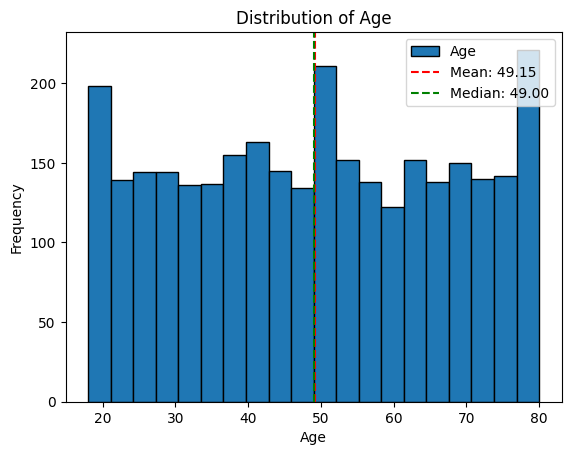

Mean Age: 49.15
Median Age: 49.00


In [312]:
plot_age_distribution(df)

print(f"Mean Age: {df['Age'].mean():.2f}")
print(f"Median Age: {df['Age'].median():.2f}")

In [313]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['AvgDaysBetweenPurchases'] = df['AvgDaysBetweenPurchases'].fillna(df['AvgDaysBetweenPurchases'].median())

print(f"Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after imputation:
Series([], dtype: int64)


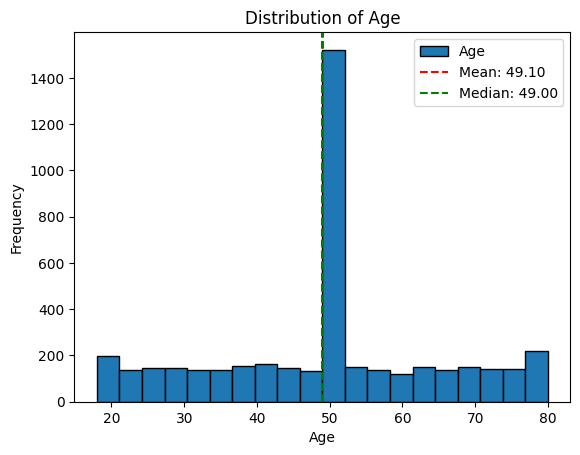

In [314]:
plot_age_distribution(df)

# They're equiprobably, 30% are missing so 30% are send to the median which skews the distribution heavily towards it.
# This cannot be right.

Given that that entirely skews the data. I'll look into the k means approach

In [315]:
df = pd.read_csv('../data/raw/retail_customers_COMPLETE_CATEGORICAL.csv')

df = preprocess_data(df)

Missing values after K-means imputation:
Age    0
dtype: int64


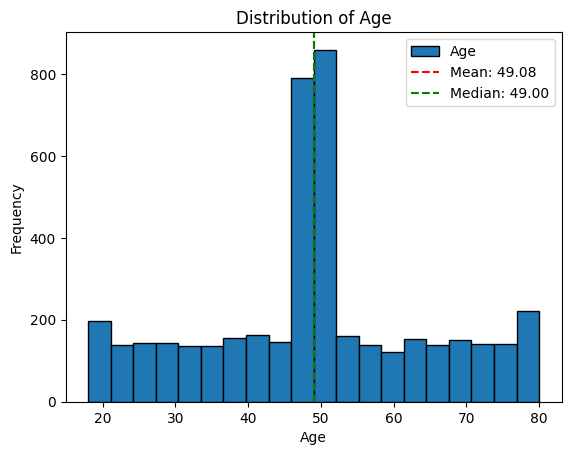

Mean Age: 49.08
Median Age: 49.00


In [316]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

targets = ["Age"]
numeric_cols = df.select_dtypes(include="number").columns.tolist()

for target in targets:
    if target not in df.columns or df[target].isna().sum() == 0:
        continue

    feature_cols = [c for c in numeric_cols if c != target]
    known_mask = df[target].notna()
    missing_mask = df[target].isna()

    if not feature_cols:
        print(f"No numeric features available to impute {target}. Filling with median.")
        df.loc[missing_mask, target] = df.loc[known_mask, target].median()
        continue

    X_train = df.loc[known_mask, feature_cols].copy()
    X_missing = df.loc[missing_mask, feature_cols].copy()

    fill_vals = X_train.median().fillna(0)
    X_train = X_train.fillna(fill_vals)
    X_missing = X_missing.fillna(fill_vals)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_missing_scaled = scaler.transform(X_missing)

    n_clusters_to_use = min(6, len(X_train))
    
    kmeans = KMeans(n_clusters=n_clusters_to_use, random_state=42, n_init="auto")
    train_clusters = kmeans.fit_predict(X_train_scaled)
    missing_clusters = kmeans.predict(X_missing_scaled)

    cluster_target = (
        pd.DataFrame(
            {"cluster": train_clusters, target: df.loc[known_mask, target].values}
        )
        .groupby("cluster")[target]
        .median()
    )

    fallback = df.loc[known_mask, target].median()
    imputed_values = [cluster_target.get(c, fallback) for c in missing_clusters]
    df.loc[missing_mask, target] = imputed_values

print("Missing values after K-means imputation:")
print(df[targets].isna().sum())

plot_age_distribution(df)

print(f"Mean Age: {df['Age'].mean():.2f}")
print(f"Median Age: {df['Age'].median():.2f}")